First rows of the loaded database:
   customerID churn_original  gender  senior_citizen  partner  dependents  \
0  0002-ORFBO             No  Female               0        1           1   
1  0003-MKNFE             No    Male               0        0           0   
2  0004-TLHLJ            Yes    Male               0        0           0   
3  0011-IGKFF            Yes    Male               0        1           0   
4  0013-EXCHZ            Yes  Female               0        1           0   

   tenure  phone_service  multiple_lines internet_service  ...  tech_support  \
0       9              1               0              DSL  ...             1   
1       9              1               1              DSL  ...             0   
2       4              1               0      Fiber optic  ...             0   
3      13              1               0      Fiber optic  ...             0   
4       3              1               0      Fiber optic  ...             1   

   streaming_tv  stre

/tmp/ipython-input-1-3646873545.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_correlations.values, y=churn_correlations.index, palette='coolwarm')


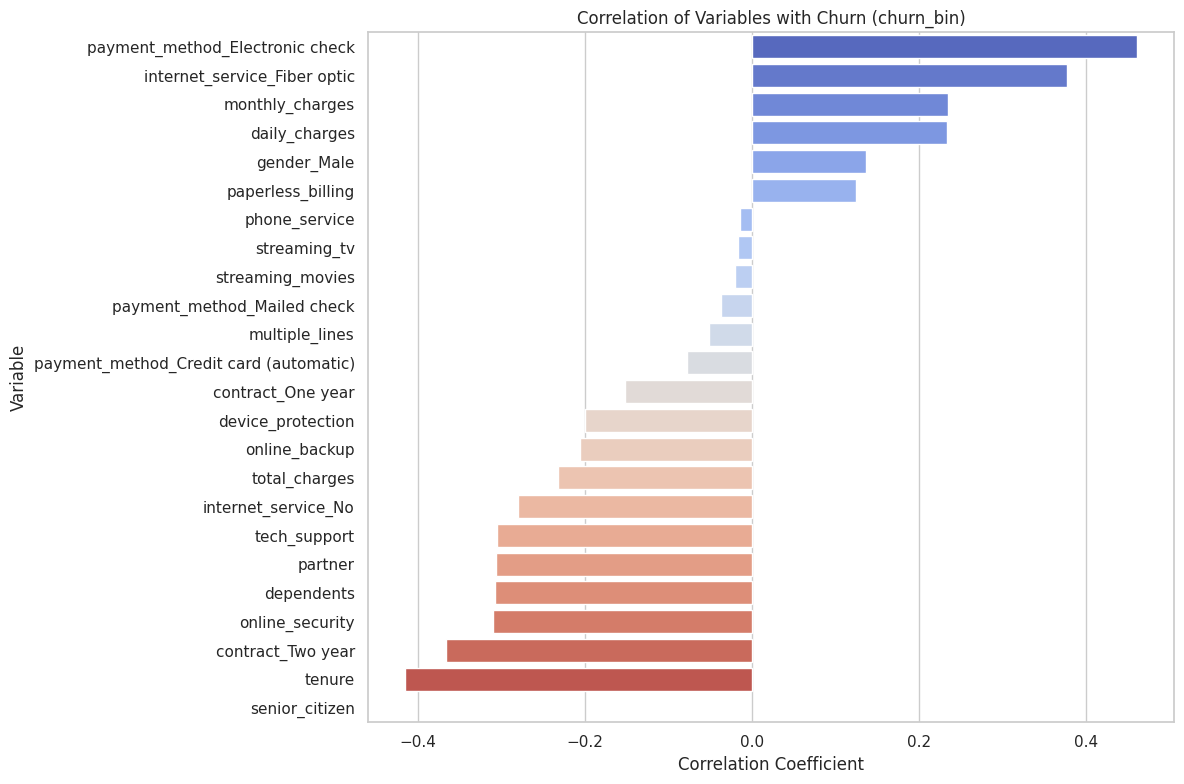


Observation: Values close to 1 indicate strong positive correlation with churn (increase the likelihood of churn).
Values close to -1 indicate strong negative correlation (decrease the likelihood of churn).


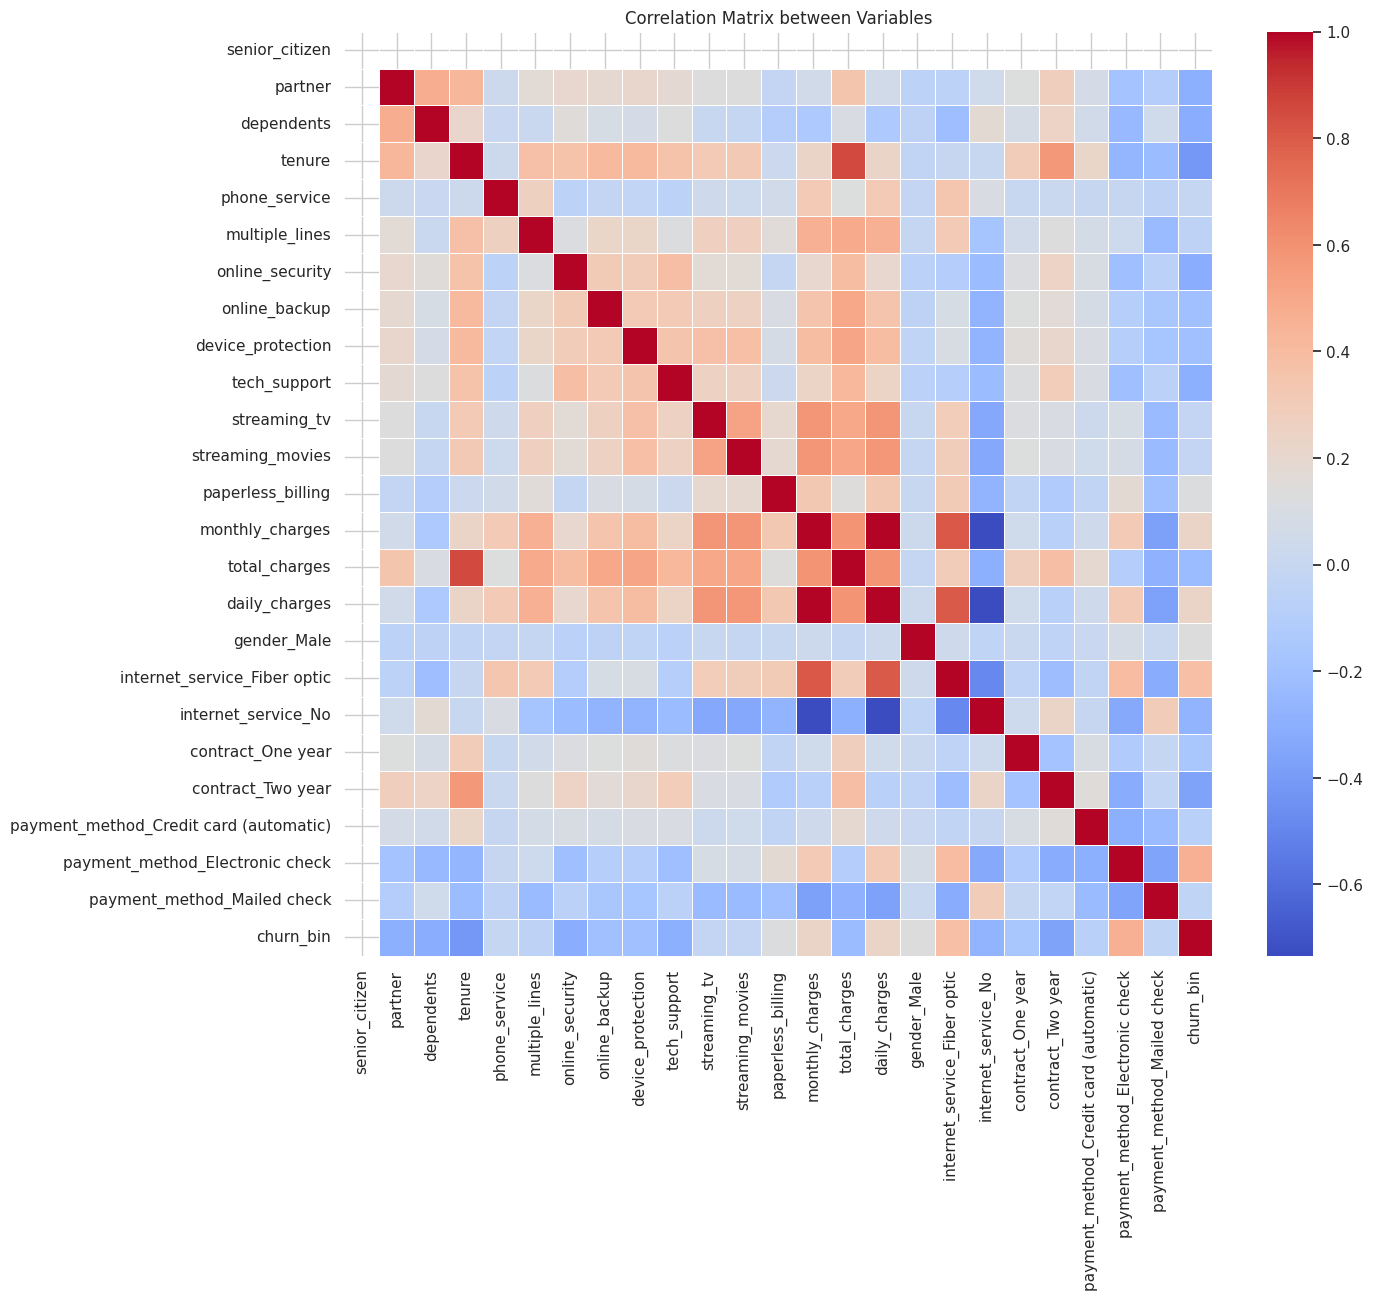


--- Relationship of specific variables with churn ---


/tmp/ipython-input-1-3646873545.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_bin', y='tenure', data=df_corr_analysis, palette='pastel')


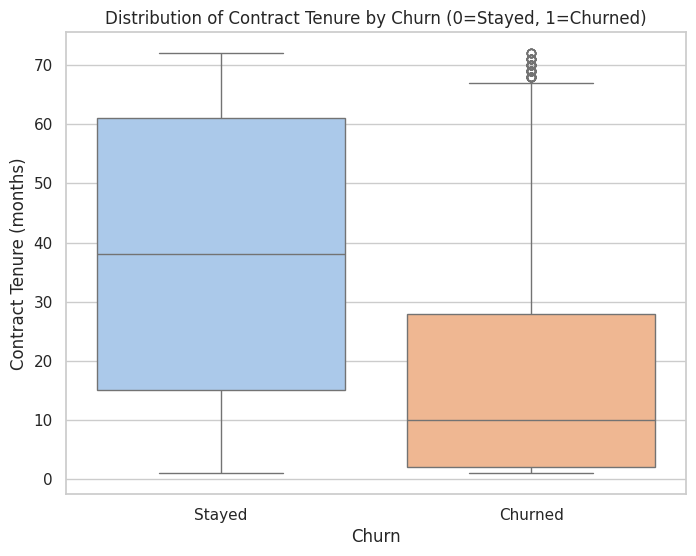

/tmp/ipython-input-1-3646873545.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_bin', y='total_charges', data=df_corr_analysis, palette='pastel')


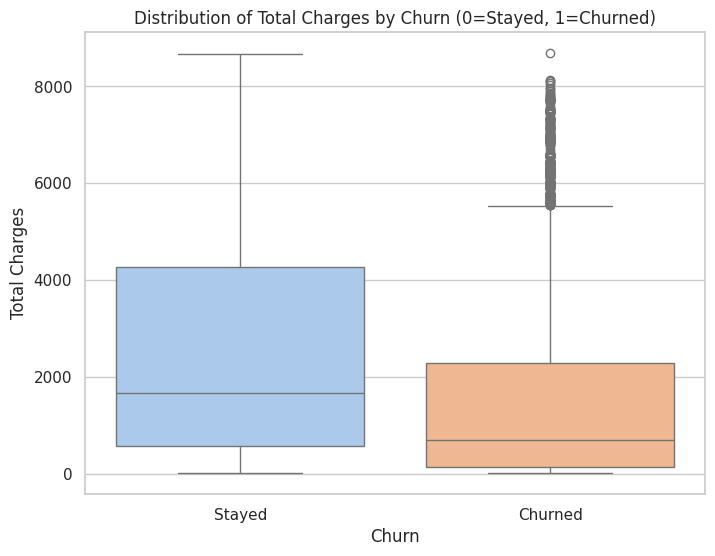


Scaled training and test data for models sensitive to scale.

--- Training and Evaluating the Logistic Regression Model ---

Logistic Regression Metrics:
Accuracy: 0.8228
Precision: 0.8193
Recall: 0.8283
F1-score: 0.8238

Confusion Matrix (Logistic Regression):
[[1266  283]
 [ 266 1283]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1549
           1       0.82      0.83      0.82      1549

    accuracy                           0.82      3098
   macro avg       0.82      0.82      0.82      3098
weighted avg       0.82      0.82      0.82      3098


--- Training and Evaluating the Random Forest Model ---

Random Forest Metrics:
Accuracy: 0.8428
Precision: 0.8298
Recall: 0.8625
F1-score: 0.8458

Confusion Matrix (Random Forest):
[[1275  274]
 [ 213 1336]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.86      0.8

/tmp/ipython-input-1-3646873545.py:262: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importancia_rf.head(10), palette='viridis')


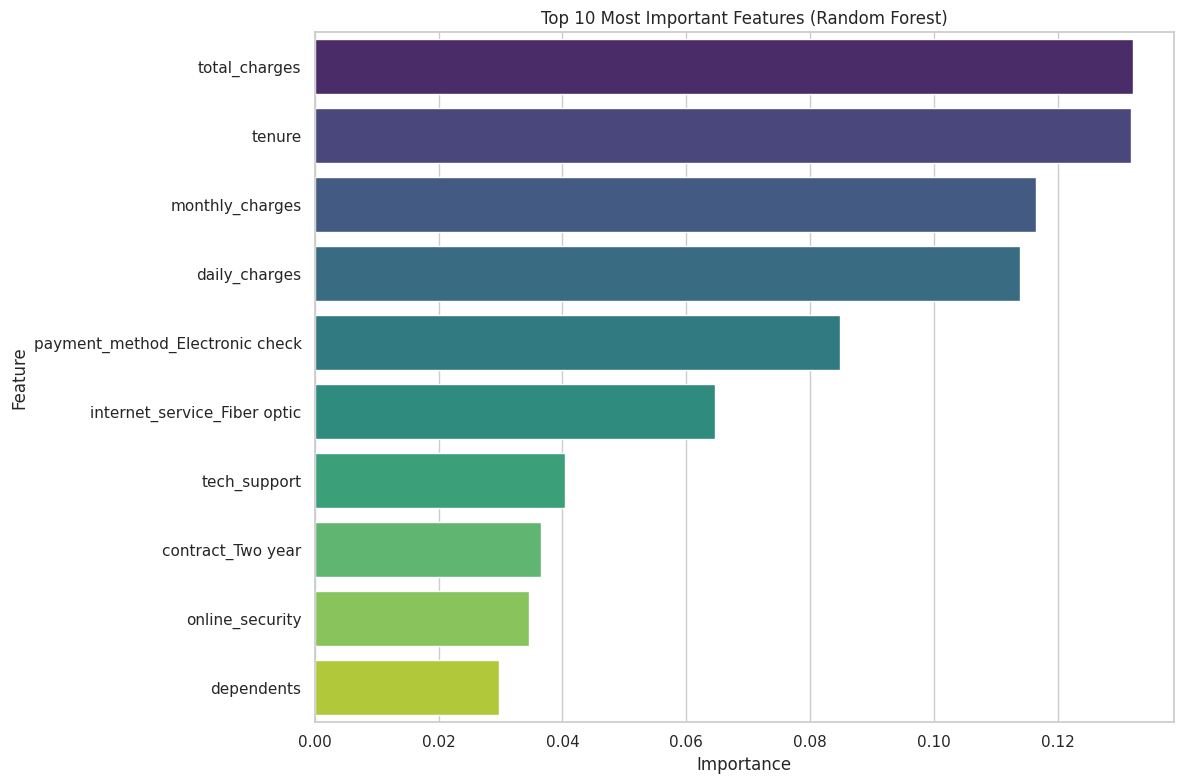


--- Strategic Conclusion and Recommendations ---

Based on the analysis and predictive models (especially Random Forest, which demonstrated the best performance in identifying at-risk customers), the main factors influencing customer churn at Telecom X are:

**1. Contract Tenure (Tenure):**
   - Customers with shorter contract tenure have a significantly higher probability of churning. This is consistently highlighted by both models and the exploratory analysis.
   - **Recommendation:** Focus on robust welcome programs for new customers, offer incentives for long-term contracts from the outset, and actively monitor customer engagement in the first few months.

**2. Contract Type:**
   - Month-to-month contracts are strongly associated with high churn rates, while one-year or two-year contracts drastically reduce churn.
   - **Recommendation:** Create campaigns to encourage customers to migrate from monthly plans to annual or biennial plans, offering discounts or additional benefits. E

In [1]:
# TELECOM X – PART 2: CHURN PREDICTION

# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE # For class balancing

# Setting the visual style for plots with seaborn
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

# --- 1. Loading the Processed Database ---
df_clientes = pd.read_csv('/content/TelecomX_datos.csv')
df_clientes['churn_bin'] = df_clientes['churn_bin'].astype(int)

# Displaying the first rows of the loaded database for verification
print("First rows of the loaded database:")
print(df_clientes.head())
print("\nData types of the columns:")
print(df_clientes.dtypes)


# --- 2. Data Preparation for Modeling ---

# 2.1. Removing columns that do not add value for analysis or predictive models
# 'customer_id' is a unique identifier and 'churn_original' is the string version of our target variable.
columns_to_drop = ['churn_original'] # Always drop churn_original
columns_to_drop.append('customerID')
df_modelagem = df_clientes.drop(columns=columns_to_drop).copy()

# 2.2. Transforming categorical variables into numerical format (One-Hot Encoding)
# Identifying remaining categorical columns
colunas_categoricas = df_modelagem.select_dtypes(include='object').columns

print(f"\nCategorical columns before One-Hot Encoding: {colunas_categoricas.tolist()}")

# Display unique elements of each categorical column
print("\nUnique elements per categorical column before One-Hot Encoding:")
for col in colunas_categoricas:
    print(f"- '{col}': {df_modelagem[col].unique().tolist()}")


# Applying One-Hot Encoding using pd.get_dummies
# drop_first=True is used to avoid multicollinearity by dropping one category per feature.
# For example, if 'contract' has 'Month-to-month', 'One year', 'Two year',
# and 'Month-to-month' is dropped, then (0,0) for 'One year' and 'Two year' implies 'Month-to-month'.
df_modelagem = pd.get_dummies(df_modelagem, columns=colunas_categoricas, drop_first=True)

print("\nFirst rows of the DataFrame after One-Hot Encoding (focus on 'contract_' columns):")
# Filter columns starting with 'contract_' to verify encoding
contract_encoded_cols = [col for col in df_modelagem.columns if col.startswith('contract_')]
print(df_modelagem[contract_encoded_cols].head())
print("\nIf 'contract_One year' and 'contract_Two year' are False (or 0), it means the original category was 'Month-to-month'.")


# Defining the target variable (y) and the predictor variables (X)
X = df_modelagem.drop('churn_bin', axis=1)
y = df_modelagem['churn_bin']

# 2.3. Evaluating class imbalance and applying balancing
print("\n--- Class Proportion before Balancing ---")
print(y.value_counts(normalize=True))

# If there is significant imbalance (e.g., one class < 30% of the other), apply SMOTE.
# SMOTE (Synthetic Minority Over-sampling Technique) is used to create synthetic samples
# of the minority class, helping models learn from imbalanced datasets more effectively.
if y.value_counts(normalize=True)[0] < 0.7 or y.value_counts(normalize=True)[1] < 0.7:
    print("\n--- Applying SMOTE to balance classes ---")
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print("Class Proportion after SMOTE:")
    print(y_balanced.value_counts(normalize=True))
    X = X_balanced # Update X and y to the balanced datasets
    y = y_balanced
else:
    print("\n--- Classes are already reasonably balanced, SMOTE not applied. ---")

# 2.4. Data Normalization/Standardization (Normalization of the entire X set for general analysis)
# This creates a scaled version of the entire X dataset.
# It's useful for exploratory analysis or visualizations, but should NOT be used directly
# for the train/test split to avoid data leakage.
scaler_general = StandardScaler()
X_scaled_general = scaler_general.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled_general, columns=X.columns)
print("\nFull scaled DataFrame (X_scaled_df) created for general analysis.")


# --- 3. Correlation Analysis and Feature Selection ---

# 3.1. Correlation Matrix
# For the correlation matrix, we will use the original DataFrame (or the balanced one, if SMOTE was applied)
# and include the target variable to see correlations with churn.
df_corr_analysis = X.copy()
df_corr_analysis['churn_bin'] = y

print("\n--- Correlation Analysis ---")
matriz_correlacao = df_corr_analysis.corr()

# Correlation of variables with 'churn_bin' (ordered)
print("\nCorrelation of variables with 'churn_bin' (ordered):")
churn_correlations = matriz_correlacao['churn_bin'].sort_values(ascending=False).drop('churn_bin', errors='ignore')
print(churn_correlations.head(10)) # Top 10 positive correlations
print(churn_correlations.tail(10)) # Top 10 negative correlations

# Visualization of variable correlations with 'churn_bin'
plt.figure(figsize=(12, 8))
sns.barplot(x=churn_correlations.values, y=churn_correlations.index, palette='coolwarm')
plt.title('Correlation of Variables with Churn (churn_bin)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()
print("\nObservation: Values close to 1 indicate strong positive correlation with churn (increase the likelihood of churn).")
print("Values close to -1 indicate strong negative correlation (decrease the likelihood of churn).")


plt.figure(figsize=(14, 12))
sns.heatmap(matriz_correlacao, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix between Variables')
plt.show()

# 3.2. Relationship of specific variables with churn
print("\n--- Relationship of specific variables with churn ---")

# Contract Tenure (tenure) vs. Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='churn_bin', y='tenure', data=df_corr_analysis, palette='pastel')
plt.title('Distribution of Contract Tenure by Churn (0=Stayed, 1=Churned)')
plt.xlabel('Churn')
plt.ylabel('Contract Tenure (months)')
plt.xticks(ticks=[0, 1], labels=['Stayed', 'Churned'])
plt.show()

# Total Charges (total_charges) vs. Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x='churn_bin', y='total_charges', data=df_corr_analysis, palette='pastel')
plt.title('Distribution of Total Charges by Churn (0=Stayed, 1=Churned)')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.xticks(ticks=[0, 1], labels=['Stayed', 'Churned'])
plt.show()


# --- 4. Model Training and Evaluation ---

# 4.1. Splitting the dataset into training and test sets
# We will use the balanced data (X, y) for the split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# For the model that requires normalization, we need to scale the training and test sets separately.
# This is CRUCIAL to avoid data leakage.
# The scaler must 'learn' the scaling parameters (mean and standard deviation) ONLY from the training data.
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train) # Fits and transforms ONLY the training data
# Then, use the SAME fitted scaler to transform the test data.
X_test_scaled = scaler_model.transform(X_test) # Transforms the test data using parameters learned from training

# Converting back to DataFrame to retain column names (useful for feature importance)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("\nScaled training and test data for models sensitive to scale.")


# 4.2. Training two classification models

# Model 1: Logistic Regression (requires normalization)
# Justification: It is a simple linear model, good for interpreting coefficients and serves as a baseline.
# It requires normalization so that different feature scales do not unduly influence the weights.
print("\n--- Training and Evaluating the Logistic Regression Model ---")
model_lr = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' is good for smaller datasets
model_lr.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_lr = model_lr.predict(X_test_scaled)
print("\nLogistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_lr):.4f}")
print("\nConfusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# Model 2: Random Forest (does not require normalization)
# Justification: It is an ensemble model based on decision trees, robust, handles non-linearities well,
# and is not sensitive to the scale of features. Generally offers good performance.
print("\n--- Training and Evaluating the Random Forest Model ---")
model_rf = RandomForestClassifier(random_state=42, n_estimators=100) # n_estimators is the number of trees
model_rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = model_rf.predict(X_test)
print("\nRandom Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# --- 5. Critical Analysis and Model Comparison ---
print("\n--- Critical Analysis and Model Comparison ---")
print("Both models, Logistic Regression and Random Forest, showed good performance in churn prediction.")

# Checking for overfitting/underfitting (comparing training vs. test performance)
y_train_pred_lr = model_lr.predict(X_train_scaled)
y_train_pred_rf = model_rf.predict(X_train)

print(f"\nTraining Accuracy (Logistic Regression): {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"Test Accuracy (Logistic Regression): {accuracy_score(y_test, y_pred_lr):.4f}")

print(f"Training Accuracy (Random Forest): {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"Test Accuracy (Random Forest): {accuracy_score(y_test, y_pred_rf):.4f}")

print("\nObservations:")
print("- The Random Forest generally exhibits very high training accuracy, indicating it 'learns' the training data very well. However, its robust test accuracy (0.8428) demonstrates good generalization capability, even with this difference. To mitigate more severe overfitting in future scenarios, we could consider hyperparameter tuning (e.g., `max_depth` or `min_samples_leaf`) or increasing the data volume.")
print("- Logistic Regression, being a simpler model, tends to have a smaller difference between training and test accuracy, which may indicate less overfitting and greater stability in its generalization.")
print("- For this business problem, **Recall** is a crucial metric, as we want to identify as many customers as possible who will churn (positive class) to proactively intervene. Random Forest stands out with a Recall of 0.8625, superior to Logistic Regression (0.8283).")
print("- The **F1-score** (0.8458 for Random Forest vs. 0.8238 for Logistic Regression) is a good balance between Precision and Recall, and Random Forest also demonstrates better performance here, indicating a superior balance in class classification.")
print("\nBased on these metrics, **Random Forest is the preferred model** for this churn prediction task, due to its better balance between precision and recall, and its higher ability to identify customers who are truly at risk of churning.")


# --- 6. Feature Importance Analysis ---

print("\n--- Feature Importance Analysis ---")

# Feature importance for Logistic Regression
# Coefficients indicate the strength and direction of the relationship with the target variable.
# Larger coefficients (in absolute value) indicate greater importance.
coeficientes_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nTop 10 Most Impactful Features (Logistic Regression - Coefficients):")
print(coeficientes_lr.head(10))
print("\nTop 10 Least Impactful / Inversely Correlated Features (Logistic Regression - Coefficients):")
print(coeficientes_lr.tail(10))

# Feature importance for Random Forest
# feature_importances_ measures each feature's contribution to impurity reduction in the trees.
importancia_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(importancia_rf.head(10))

# Visualization of feature importance (Random Forest)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importancia_rf.head(10), palette='viridis')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 7. Strategic Conclusion and Recommendations ---

print("\n--- Strategic Conclusion and Recommendations ---")

print("\nBased on the analysis and predictive models (especially Random Forest, which demonstrated the best performance in identifying at-risk customers), the main factors influencing customer churn at Telecom X are:")
print("\n**1. Contract Tenure (Tenure):**")
print("   - Customers with shorter contract tenure have a significantly higher probability of churning. This is consistently highlighted by both models and the exploratory analysis.")
print("   - **Recommendation:** Focus on robust welcome programs for new customers, offer incentives for long-term contracts from the outset, and actively monitor customer engagement in the first few months.")

print("\n**2. Contract Type:**")
print("   - Month-to-month contracts are strongly associated with high churn rates, while one-year or two-year contracts drastically reduce churn.")
print("   - **Recommendation:** Create campaigns to encourage customers to migrate from monthly plans to annual or biennial plans, offering discounts or additional benefits. Emphasize the stability and long-term benefits.")

print("\n**3. 'Electronic Check' Payment Method:**")
print("   - This payment method showed a strong correlation with churn and was one of the most important variables for Random Forest. This may indicate problems with the payment experience or general dissatisfaction associated with this customer group.")
print("   - **Recommendation:** Thoroughly investigate the cause of dissatisfaction among customers using 'Electronic Check'. It could be a technical issue, lack of convenience, or simply an indicator of less engaged customers. Offer more convenient and secure payment alternatives.")

print("\n**4. Internet Services (Fiber Optic):**")
print("   - Interestingly, customers with Fiber Optic service showed a higher churn rate compared to other internet types or no internet service, being a relevant variable in the models. This suggests that, despite being a premium service, the customer experience may not be meeting expectations.")
print("   - **Recommendation:** Re-evaluate the quality and stability of the fiber optic service. There may be issues with latency, interruptions, or inadequate technical support. A specific satisfaction survey with these customers could reveal valuable insights.")

print("\n**5. Additional Services (Online Security, Tech Support, Online Backup):**")
print("   - Adherence to additional services like online security, backup, and technical support tends to reduce the likelihood of churn. Customers who use these services feel more 'tied in' and valued, and these variables showed importance in the models.")
print("   - **Recommendation:** Actively promote the contracting of service packages that include these add-ons. Highlight the value and security these services offer, perhaps with a free trial period or initial discounts.")

print("\n**6. Monthly Charges and Total Charges:**")
print("   - 'Monthly Charges' has a positive correlation with churn and was one of the most important variables for Random Forest. Customers with very high monthly fees may be more prone to seek alternatives. 'Total Charges', on the other hand, has a negative correlation, indicating that customers with higher accumulated spending tend to stay.")
print("   - **Recommendation:** Review the pricing structure, especially for plans with high monthly fees. Offer flexibility or more competitive packages for high-spending customers, ensuring that the perceived value justifies the cost. For 'Total Charges', focus on loyalty programs for long-term, high-value customers.")

print("\nIn summary, Telecom X should focus on proactive strategies to retain customers, especially new ones and those on monthly contracts, thoroughly investigating the causes of dissatisfaction related to payment methods and the perceived quality of premium services like fiber optic. Promoting additional services and offering long-term contracts are promising avenues to strengthen customer loyalty. The prioritization of these actions should be guided by the importance of the variables identified by the predictive models.")
